In [5]:
%run ../../_setup.py

import numpy as np
import xarray as xr
from netCDF4 import Dataset
from pandas import to_datetime
from scipy.interpolate import griddata

import pyproj

from gsw import IPV_vs_fNsquared_ratio, f, Nsquared

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cmo

## Relative and absolute vorticity from SSH

In [6]:
# load altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')
ssh = xr.open_dataset(input_file)

# transform polar in cartesian coordinate system
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# select data range
west = 137
south = -52.4
east = 147
north = -48

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north))

timevoy = slice('1998-03-10', '1998-03-28')

# load bathymetry (1 arc-minute resolution)
# input_file = os.path.join(datadir, 'external', 'bathymetry', 'smith_and_sandwell_1997', 
#                           'bathymetry_-48_137_-58_157.nc')
input_file = os.path.join(datadir, 'external', 'bathymetry', 'bodc_res30sec', 
                          'GEBCO_2014_2D_137.0_-58.0_147.0_-48.0.nc')
bathy = xr.open_dataset(input_file)

# dep = bathy.sel(longitude=slice(west, east), latitude=slice(north, south))

# boundaries
north = -52.4
west = 137
south = -48
east = 147

dep = bathy.elevation.sel(lon=slice(west, east), lat=slice(north, south))

try:
    lonH, latH = dep.longitude, dep.latitude
except:
    lonH, latH = dep.lon, dep.lat

lonlonH, latlatH = np.meshgrid(lonH, latH)

In [55]:

# xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)

loni, lati = ssh.longitude.data, ssh.latitude.data
lonlon, latlat = np.meshgrid(loni, lati)
xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)

# calculate flow speed, relative vorticity and divergence
zeta = np.ma.masked_all(ssh.ugos.shape)
dzetadx, dzetady = zeta.copy(), zeta.copy()
Sn, Ss = zeta.copy(), zeta.copy()
for t in range(len(ssh.time)):
    dvdx = np.gradient(ssh.vgos[t,])[1] / np.gradient(xx)[1]
    dudy = np.gradient(ssh.ugos[t,])[0] / np.gradient(yy)[0]
    
    dudx = np.gradient(ssh.ugos[t,])[0] / np.gradient(xx)[1]
    dvdy = np.gradient(ssh.vgos[t,])[1] / np.gradient(yy)[0]

    zeta[t,] = dvdx - dudy
    dzetadx[t,] = np.gradient(zeta[t,])[1] / np.gradient(xx)[1]
    dzetady[t,] = np.gradient(zeta[t,])[0] / np.gradient(yy)[0]

    Sn[t,] = dudx - dvdy
    Ss[t,] = dvdx + dudy
#     div[t,] = dudx + dvdy

zeta = xr.DataArray(zeta, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
dzetadx = xr.DataArray(dzetadx, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
dzetady = xr.DataArray(dzetady, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

udivzeta = ssh.ugos.sel(time=timevoy).mean('time').data * dzetadx.sel(time=timevoy).mean('time').data + \
ssh.vgos.sel(time=timevoy).mean('time').data * dzetady.sel(time=timevoy).mean('time').data


# Okubu-Weiss parameter
# Sn = xr.DataArray(Sn, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
# Ss = xr.DataArray(Ss, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

# OW = Sn**2 + Ss**2 - zeta**2

# determine planetary vorticity
fcor = f(latlat)

# grid bathymetry on ssh grid
# points = list(zip(lonlonH[:].flatten(), latlatH[:].flatten()))
# values = dep.data.flatten()
# H = griddata(points, values, (lonlon, latlat), method='linear')
fcorH = f(latlatH)

# average dynamic height contours over time of the voyage
# D = np.mean(ssh.adt[timevoy], axis=0)

In [58]:
udivzeta.min()

-1.2981282209074159e-10

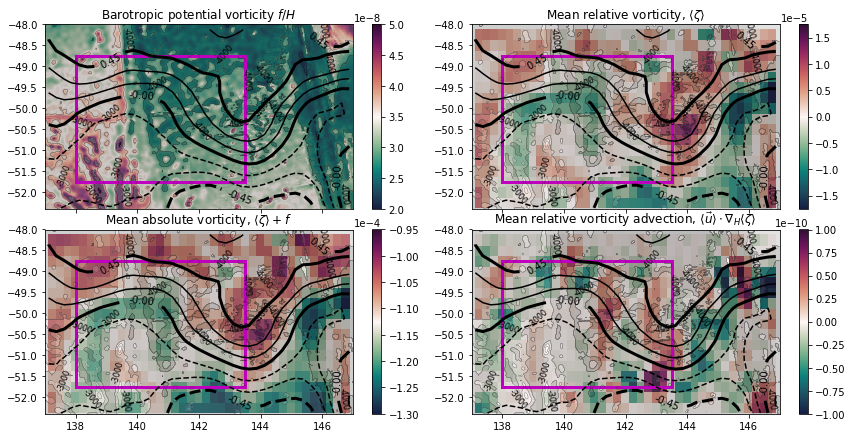

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
fig.tight_layout()

# barotropic potential vorticity
vmin, vmax = 2e-8, 5e-8
pcol = ax[0, 0].pcolor(lonH, latH, fcorH/dep,
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
plt.colorbar(pcol, ax=ax[0, 0])
ax[0, 0].set_title('Barotropic potential vorticity $f/H$')

# mean relative vorticity
vmin, vmax = -1.75e-5, 1.75e-5
pcol = ax[0, 1].pcolor(loni, lati, zeta.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0, 1])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax[0, 1].set_title(r'Mean relative vorticity, $\langle\zeta\rangle$')

# mean absolute vorticity
vmin, vmax = -0.95e-4, -1.3e-4
pcol = ax[1, 0].pcolor(loni, lati, zeta.sel(time=timevoy).mean('time') + fcor, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 0])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax[1, 0].set_title(r'Mean absolute vorticity, $\langle\zeta\rangle + f$')

# mean relative vorticity advection
vmin, vmax = -1e-10, 1e-10
pcol = ax[1, 1].pcolor(loni, lati, udivzeta, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 1])
ax[1, 1].set_title(r'Mean relative vorticity advection, $\langle\vec{u}\rangle\cdot\nabla_H\langle\zeta\rangle$')

bounds = np.linspace(-0.45, 0.75, 9)
depths = np.linspace(-5000, -1000, 5)
# for i in range(len(ax)):
row, col = ax.shape
for r in range(row):
    for c in range(col):    
        # plot dynamic height contours
        ct = ax[r, c].contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'), bounds, colors='k')
        for ib, b in enumerate(bounds):
            if b in bounds[0::3]:
                zc = ct.collections[ib]
                plt.setp(zc, linewidth=3)
        ax[r, c].clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

        # plot depth contours
        ax[r, c].contourf(lonlonH, latlatH, dep, depths, 
                           cmap=plt.cm.binary_r, alpha=0.3)
        dc = ax[r, c].contour(lonlonH, latlatH, dep, depths, 
                           colors='k', linewidths=0.2, linestyles='solid')
        ax[r, c].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

        # plot observations domain
        ax[r, c].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
                   facecolor='none', edgecolor='m', linewidth=3)
    
#     ax[i].set_aspect('equal')

## Strain-shear Okubu-Weiss parameter from SSH

In [126]:
7.4e-11 + 10e-11

1.7400000000000002e-10

Text(0.5, 1.0, 'Okubo-Weiss parameter')

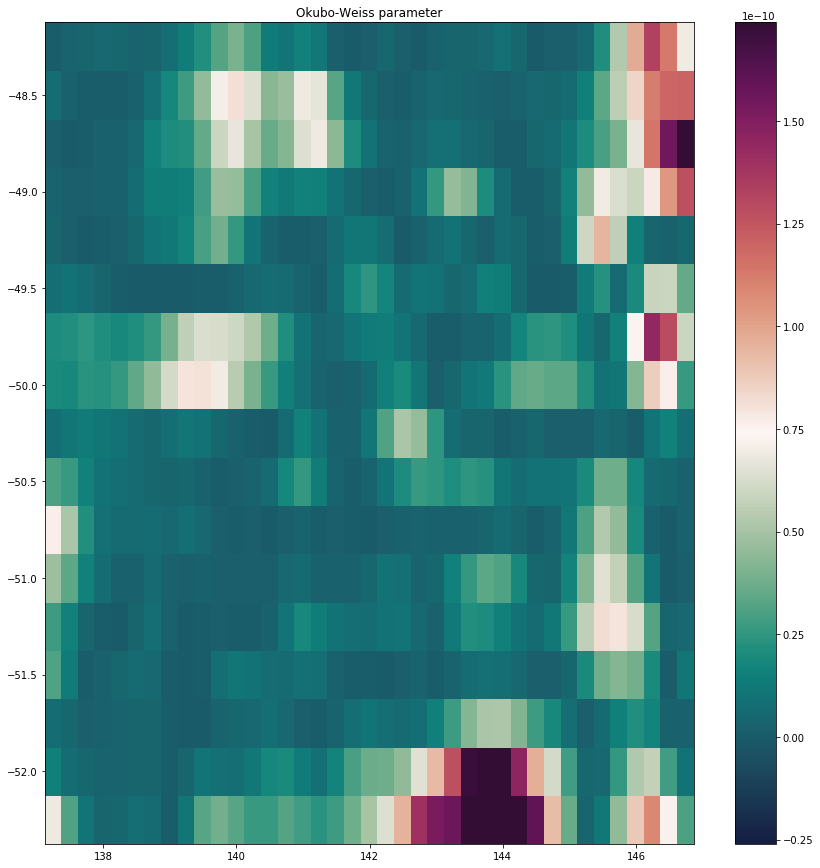

In [127]:
fig, ax = plt.subplots(figsize=(12, 12), sharex=True)
fig.tight_layout()

# plot relative vorticity field
# vmin, vmax = -1.75e-5, 1.75e-5
vmin, vmax = -2.6e-11, 1.74e-10
axis=0
pcol = ax.pcolor(loni, lati, OW.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
plt.colorbar(pcol)
ax.set_title('Okubo-Weiss parameter')

# for i in range(len(ax)):
    
#     # plot dynamic height contours
#     ct = ax[i].contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'), bounds, colors='k')
#     for ib, b in enumerate(bounds):
#         if b in bounds[0::3]:
#             zc = ct.collections[ib]
#             plt.setp(zc, linewidth=3)
#     ax[i].clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')
    
#     # plot depth contours
#     ax[i].contourf(lonlonH, latlatH, dep, depths, 
#                        cmap=plt.cm.binary_r, alpha=0.3)
#     dc = ax[i].contour(lonlonH, latlatH, dep, depths, 
#                        colors='k', linewidths=0.2, linestyles='solid')
#     ax[i].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

#     # plot observations domain
#     ax[i].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
#                facecolor='none', edgecolor='m', linewidth=3)

## Potential vorticity from CTD profiles per transect

In [5]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

In [6]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# transect stations
transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
             4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}


# calculate Isopycnal Potential Vorticity
IPV_fN2, p_mid = IPV_vs_fNsquared_ratio(ctd['SA'][:], ctd['CT'][:], ctd['p'][:], p_ref=p_ref, axis=1)
N2 = Nsquared(ctd['SA'][:], ctd['CT'][:], ctd['p'][:], ctd['lat'][:, 0], axis=1,)[0]
fcor = np.broadcast_to(f(ctd['lat'][:, 0])[np.newaxis,:].T, IPV_fN2.shape)

IPV = IPV_fN2 * fcor * N2


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


In [7]:
pressure_levels = {}
for ip, p in enumerate(p_mid[0].data):
    pressure_levels[p] = ip


## Buoyancy frequency

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


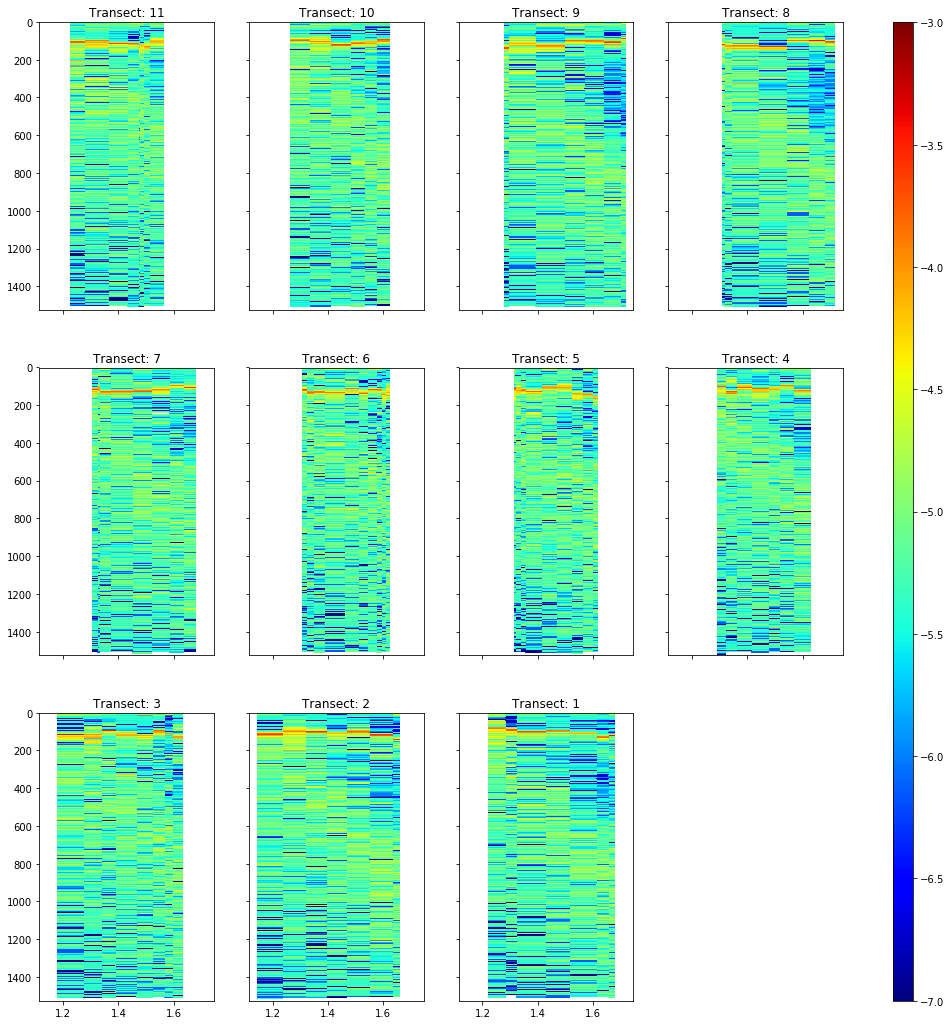

In [8]:
cmap = cmo.cm.curl
# bounds = np.linspace(-5e-9, 5e-9, 21)
# norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True)

for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], ctd['p'][:], np.log10(N2[stations]).T, cmap=plt.cm.jet, vmin=-7, vmax=-3)

    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])

In [9]:
# p_int = 401 #dbar
# lon = ctd['lon'][:, 0]
# ip = pressure_levels[p_int]

## Horizontal PV at depth layer

https://www.ldeo.columbia.edu/~pierred/Research/mindanao/Potential_Vorticity_fields.html

In [11]:
IPV.min(), IPV.max()

(-7.128041201268494e-08, 1.816276539332689e-08)

(8,) (8, 762) (8, 762)


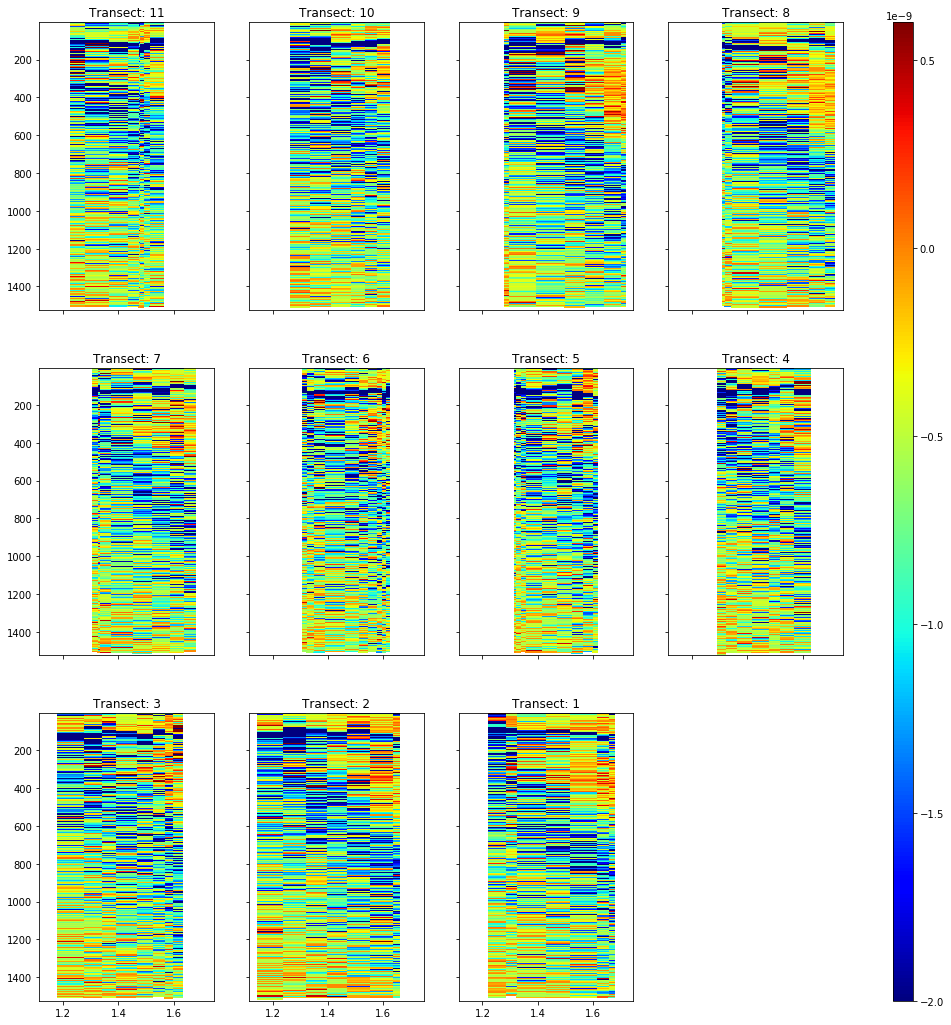

In [48]:
cmap = plt.cm.jet
# bounds = np.linspace(-5e-9, 5e-9, 21)
# norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True)

for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], p_mid[0], IPV[stations].T, cmap=cmap, vmin=-2e-9, vmax=6e-10)

    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])

print(D[stations].shape,p_mid[stations].shape,IPV[stations].shape)

# interesting structure of potential vorticity between pressure levels, especially in north of the trough and crest, but shouldn't this be done between neutral surfaces / NSPV (McDougall, 1988)

99 299


ValueError: 'c' argument has 99 elements, which is not acceptable for use with 'x' with size 198, 'y' with size 198.

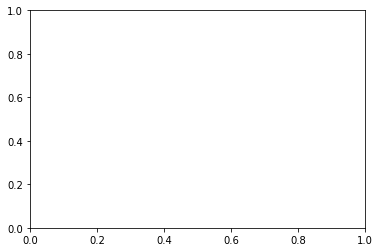

In [20]:
fig, ax = plt.subplots()

print(pressure_levels[201], pressure_levels[601])
scat = ax.scatter(ctd['lon'][2:], ctd['lat'][2:], c=np.mean(IPV[2:, pressure_levels[201]:pressure_levels[601]], axis=1), 
                  )
plt.colorbar(scat)